In [92]:
import pandas as pd
import tarfile
import tqdm
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
import numpy as np


In [93]:
# Load the faces datasets
data = fetch_olivetti_faces()
targets = data.target
images = data.images

In [94]:
def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

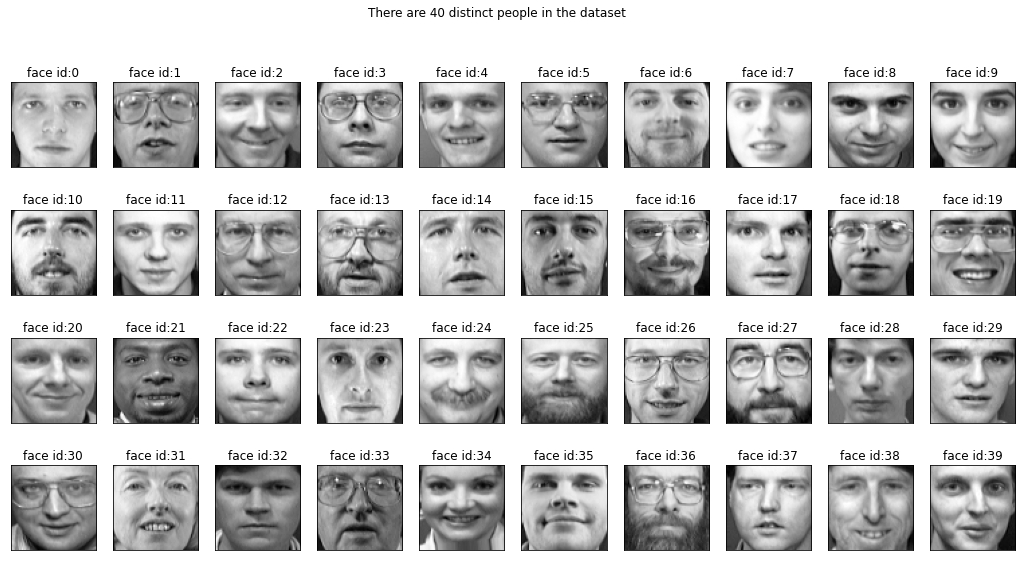

In [95]:
show_40_distinct_people(images, np.unique(targets))

In [96]:
images.shape

(400, 64, 64)

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(images, test_size=0.1)

In [98]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
     # The encoder
     encoder = Sequential()
     encoder.add(InputLayer(img_shape))
     encoder.add(Flatten())
     encoder.add(Dense(code_size, activation='sigmoid'))

      # The decoder
     decoder = Sequential()
     decoder.add(InputLayer((code_size,)))
     decoder.add(Dense(np.prod(img_shape), activation='sigmoid'))
     decoder.add(Reshape(img_shape))

     return encoder, decoder
    
 # Same as (64,64,3), we neglect the number of instances from shape
IMG_SHAPE = images.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 400)
inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = Model(inp,reconstruction)

autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_109 (InputLayer)      [(None, 64, 64)]          0         
                                                                 
 sequential_77 (Sequential)  (None, 400)               1638800   
                                                                 
 sequential_78 (Sequential)  (None, 64, 64)            1642496   
                                                                 
Total params: 3,281,296
Trainable params: 3,281,296
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
from sklearn.model_selection import KFold

# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train, X_train):

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = autoencoder.fit(x=X_train, y=X_train, epochs=2000,
                validation_data=[X_test, X_test])
  
  # Generate generalization metrics
  scores = history.history['loss']
  print(f'Loss for fold {fold_no}: {scores[0]};')
  acc_per_fold=[]
  loss_per_fold=[]
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1



Streaming output truncated to the last 5000 lines.
Epoch 1503/2000
12/12 [==============================] - 0s 6ms/step - loss: 2.9196e-05 - val_loss: 0.0037
Epoch 1504/2000
12/12 [==============================] - 0s 6ms/step - loss: 2.1990e-05 - val_loss: 0.0037
Epoch 1505/2000
12/12 [==============================] - 0s 8ms/step - loss: 1.9434e-05 - val_loss: 0.0037
Epoch 1506/2000
12/12 [==============================] - 0s 6ms/step - loss: 1.8731e-05 - val_loss: 0.0037
Epoch 1507/2000
12/12 [==============================] - 0s 6ms/step - loss: 1.7058e-05 - val_loss: 0.0037
Epoch 1508/2000
12/12 [==============================] - 0s 6ms/step - loss: 1.7940e-05 - val_loss: 0.0037
Epoch 1509/2000
12/12 [==============================] - 0s 6ms/step - loss: 1.6449e-05 - val_loss: 0.0037
Epoch 1510/2000
12/12 [==============================] - 0s 8ms/step - loss: 1.6119e-05 - val_loss: 0.0037
Epoch 1511/2000
12/12 [==============================] - 0s 7ms/step - loss: 1.7023e-05 - val

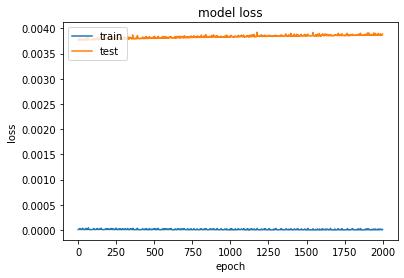

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(x)

1/1 [==============================] - 0s 51ms/step


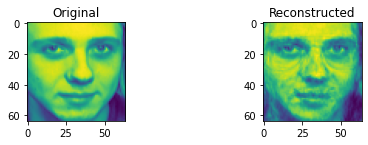

1/1 [==============================] - 0s 23ms/step


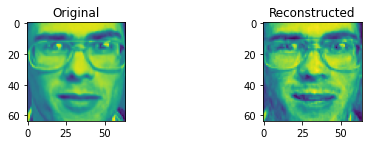

1/1 [==============================] - 0s 17ms/step


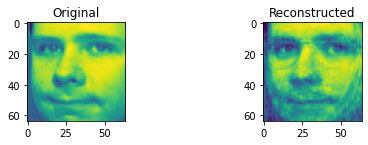

1/1 [==============================] - 0s 18ms/step


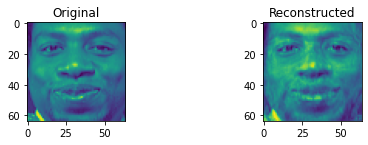

1/1 [==============================] - 0s 18ms/step


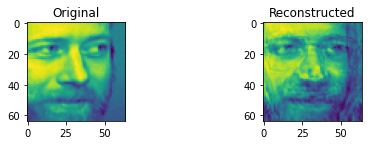

In [102]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
#     kernel = np.array([[-1,-1,-1], 
#                    [-1, 9,-1],
#                    [-1,-1,-1]])
#     image_sharp = cv2.filter2D(reco, -1, kernel)

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

#     plt.subplot(1,3,2)
#     plt.title("Code")
#     plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()
    

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [103]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

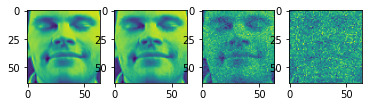

In [104]:
plt.subplot(1,4,1)
show_image(X_train[200])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[200:201],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[200:201],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[200:201],sigma=0.5)[0])

In [105]:
code_size = 400

# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(1):
    print("Epoch %i/1000, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=2000,
                    validation_data=[X_test_noise, X_test])

Epoch 1/1000, Generating corrupted samples...
Epoch 1/2000
12/12 [==============================] - 1s 18ms/step - loss: 0.0236 - val_loss: 0.0179
Epoch 2/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.0200 - val_loss: 0.0178
Epoch 3/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.0194 - val_loss: 0.0175
Epoch 4/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.0191 - val_loss: 0.0174
Epoch 5/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.0169
Epoch 6/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.0182 - val_loss: 0.0165
Epoch 7/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.0176 - val_loss: 0.0159
Epoch 8/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 9/2000
12/12 [==============================] - 0s 6ms/step - loss: 0.0161 - val_loss: 0.0147
Epoch 10/2000
12/12 [==============================] 

1/1 [==============================] - 0s 37ms/step


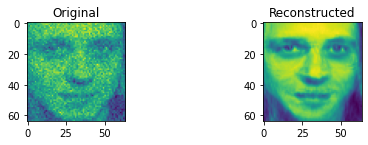

1/1 [==============================] - 0s 12ms/step


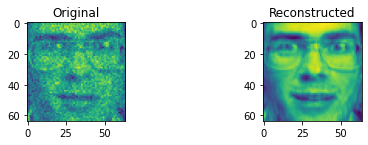

1/1 [==============================] - 0s 13ms/step


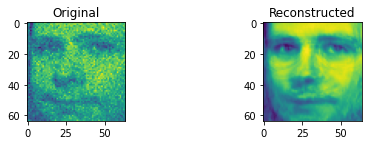

1/1 [==============================] - 0s 12ms/step


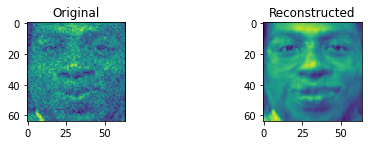

1/1 [==============================] - 0s 15ms/step


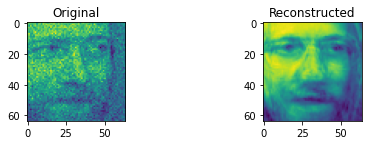

In [106]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)